# Astr 257 HR Diagram, Aditya Sengupta

In [12]:
from astropy.io import fits
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import ZScaleInterval
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from os import path
from photutils.background import MedianBackground
from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

In [13]:
datapath = "../../../Project 2--HR Diagram/data/"
getlims = ZScaleInterval().get_limits

def view_as_ds9(img, **kwargs):
    vmin, vmax = getlims(img)
    if vmin > vmax:
        vmin, vmax = vmax, vmin
    plt.imshow(img, vmin=vmin, vmax=vmax, **kwargs)

def fname_to_data(fname, calib):
    return np.dstack([fits.open(path.join(datapath, calib, fname + str(i) + ".fits"))[0].data for i in range(3)]).astype(np.float64)

darks, biases, flatsB, flatsV = map(lambda x: fname_to_data(x, "calibration"), ["dark", "bias", "flatB", "flatV"])
landBs, landVs, ngcBs, ngcVs = map(lambda x: fname_to_data(x, "ngc 6819"), ["land_b", "land_v", "ngc_b", "ngc_v"])

In [14]:
med_dark, med_bias, med_flatB, med_flatV = map(lambda x: np.nanmedian(x, axis=2), [darks, biases, flatsB, flatsV])
med_dark = med_dark - med_bias
med_flatB = med_flatB - med_bias
med_flatV = med_flatV - med_bias

mediandiv = lambda x: x / np.nanmedian(x)

corr_landBs, corr_landVs, corr_ngcBs, corr_ngcVs = [np.zeros_like(x) for x in [landBs, landVs, ngcBs, ngcVs]]
denomB = mediandiv(med_flatB - med_dark / 2)
denomV = mediandiv(med_flatV - med_dark / 6)
denomB[np.where(denomB == 0)] = 1
denomV[np.where(denomV == 0)] = 1
for i in range(3):
    corr_landBs[:,:,i] = ((landBs[:,:,i] - med_bias) - med_dark / 2) / denomB
    corr_landVs[:,:,i] = ((landVs[:,:,i] - med_bias) - med_dark / 6) / denomV
    corr_ngcBs[:,:,i] = ((ngcBs[:,:,i] - med_bias) - med_dark / 2) / denomB
    corr_ngcVs[:,:,i] = ((ngcVs[:,:,i] - med_bias) - med_dark / 6) / denomV

landB, landV, ngcB, ngcV = map(lambda x: np.nanmedian(x, axis=2), [corr_landBs, corr_landVs, corr_ngcBs, corr_ngcVs])

checking exposure times here

`fits.open(path.join(datapath, "ngc 6819", "ngc_v0.fits"))[0].header['EXPTIME'] # etc`

darks were 60 seconds

biases were 0 seconds (obv)

flatsB were 30 seconds

flatsV were 10 seconds

landB were 60 seconds

landV were 60 seconds

ngcB were 60 seconds

ngcV were 60 seconds

In [15]:
fix = lambda img: np.delete(img[:, :990], 256, 1)
if ngcB.shape[1] == 1056:
    ngcB, ngcV, landB, landV = map(fix, [ngcB, ngcV, landB, landV])

In [20]:
ngcB.shape

(1024, 989)

In [22]:
h

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 1056 / NUMBER OF COLUMNS                              
NAXIS2  =                 1024 / NUMBER OF ROWS                                 
CRVAL1U =                 2048 / COLUMN ORIGIN                                  
CRVAL2U =                 2048 / ROW ORIGIN                                     
CDELT1U =                   -2 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -2 / ROW CHANGE PER PIXEL                           
OBSNUM  =                 3158 / OBSERVATION NUMBER                             
IDNUM   =                    3 / IMAGE ID                                       
UGEOM   =                    0 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

In [32]:

for (name, data, hname) in zip(["ngcB", "ngcV", "landB", "landV"], [ngcB, ngcV, landB, landV], ["ngc_b0", "ngc_v0", "land_b0", "land_v0"]):
    fits.writeto(f"{name}.fits", data, overwrite=True)

In [26]:
h

SIMPLE  =                    T / NORMAL FITS IMAGE                              
BITPIX  =                   16 / DATA PRECISION                                 
NAXIS   =                    2 / NUMBER OF IMAGE DIMENSIONS                     
NAXIS1  =                 1024 / NUMBER OF COLUMNS                              
NAXIS2  =                  989 / NUMBER OF ROWS                                 
CRVAL1U =                 2048 / COLUMN ORIGIN                                  
CRVAL2U =                 2048 / ROW ORIGIN                                     
CDELT1U =                   -2 / COLUMN CHANGE PER PIXEL                        
CDELT2U =                   -2 / ROW CHANGE PER PIXEL                           
OBSNUM  =                 3158 / OBSERVATION NUMBER                             
IDNUM   =                    3 / IMAGE ID                                       
UGEOM   =                    0 / UCAM READOUT GEOMETRY                          
DGEOM   =                   

In [13]:
finder = DAOStarFinder(threshold=100, fwhm=3.26)

r_aperture = 7 / 0.368 # 7
def find_stars(data):
    stars = finder.find_stars(data)
    x, y = np.array(stars['xcentroid']), np.array(stars['ycentroid'])
    return np.vstack((x, y)).T

def phot(data, stars):
    _, _, sigma = sigma_clipped_stats(data)
    bkg = MedianBackground(SigmaClip(sigma))
    aperture = CircularAperture(stars, r=r_aperture)
    return aperture_photometry(data - bkg(data), aperture)

In [14]:
landB_phot = phot(landB, find_stars(landB))
landV_phot = phot(landV, find_stars(landB))
ngcB_phot = phot(ngcB, find_stars(ngcB))
ngcV_phot = phot(ngcV, find_stars(ngcB))

In [15]:
landB_phot

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,1.5972660818020339,0.6168795727808891,59697.390592723474
2,986.5082972946688,0.7493817499733455,-1677.8169824584493
3,939.231896699993,80.27497524341771,-5173.13776896373
4,979.813738672466,194.64824126050726,64833.53226539951
5,838.0109281872664,198.2394974393369,-10787.515500590747
6,508.8388170321753,208.3735971560415,6843.14982156485
7,496.97013343979046,237.31555479657425,477445.99662659055
8,4.908952005820857,434.9756319512614,13565.904099837753


In [7]:
refstar_idx = np.argmin((landB_phot['xcenter'].value - 498) ** 2 + (landB_phot['ycenter'].value - 237) ** 2)
landB_flux = landB_phot[refstar_idx]["aperture_sum"] / 60
landV_flux = landV_phot[refstar_idx]["aperture_sum"] / 60
landV_mag, landB_mag = 12.388, 12.783
zp_B = -2.5 * np.log10(1 / landB_flux) + landB_mag
zp_V = -2.5 * np.log10(1 / landV_flux) + landV_mag
mag_B = -2.5 * np.log10(ngcB_phot["aperture_sum"] / 60) + zp_B
mag_V = -2.5 * np.log10(ngcV_phot["aperture_sum"] / 60) + zp_V

/var/folders/1p/5xh_74x92lz3n_268rmhwyrc0000gn/T/ipykernel_76347/702529097.py:7: RuntimeWarning: invalid value encountered in log10
  mag_B = -2.5 * np.log10(ngcB_phot["aperture_sum"] / 60) + zp_B
/var/folders/1p/5xh_74x92lz3n_268rmhwyrc0000gn/T/ipykernel_76347/702529097.py:8: RuntimeWarning: invalid value encountered in log10
  mag_V = -2.5 * np.log10(ngcV_phot["aperture_sum"] / 60) + zp_V


In [8]:
print(zp_B, zp_V)

22.534932514398328 22.739705438940433


Text(0.5, 1.0, 'Hertzsprung-Russell diagram of NGC 6819')

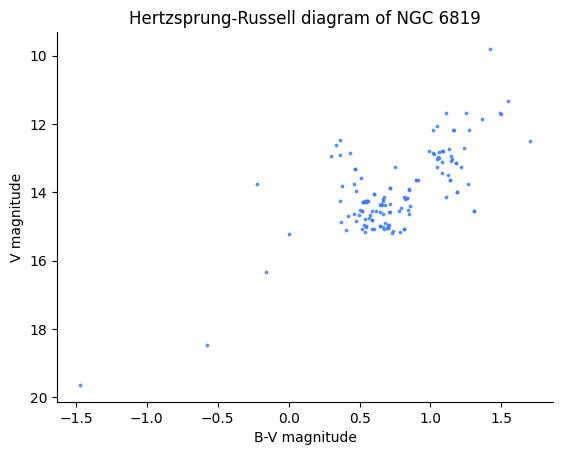

In [9]:
plt.scatter(mag_B - mag_V, mag_V, s=3, c='xkcd:lightish blue', alpha=0.75)
plt.xlabel("B-V magnitude")
plt.ylabel("V magnitude")
plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Hertzsprung-Russell diagram of NGC 6819")
plt.savefig("hr.pdf")

In [30]:
from itertools import product

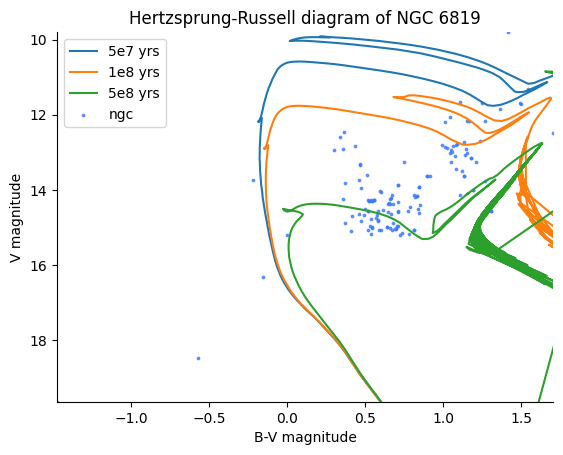

In [66]:
ages = [str(i) + "e" + str(j) for (j, i) in product([7, 8, 9, 10], [1, 5])][1:-4]
offset = 15
for age in ages:
    isochrone = pd.read_csv(path.join(datapath, f"isochrones_{age}.dat"), comment='#', delimiter='\s+', header=0)
    iso_v = isochrone["Vmag"] + offset
    iso_bmv = isochrone["Bmag"] - isochrone["Vmag"] 
    plt.plot(iso_bmv, iso_v, label=f"{age} yrs")
plt.scatter(mag_B - mag_V, mag_V, s=3, c='xkcd:lightish blue', alpha=0.75, label="ngc")
plt.xlabel("B-V magnitude")
plt.ylabel("V magnitude")
plt.xlim(np.nanmin(mag_B - mag_V), np.nanmax(mag_B - mag_V))
plt.ylim(np.nanmin(mag_V), np.nanmax(mag_V))
plt.gca().invert_yaxis()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Hertzsprung-Russell diagram of NGC 6819")
plt.legend()